Neuromorphic engineering I

## Lab 9: Silicon Neuron Circuits

Team member 1: Jan Hohenheim

Team member 2: Maxim Gärtner

Date: 25.11.21

-------------------------------------------------------------------------------------------------------------------

In this lab, we will test a circuit that generates action potentials (spikes) based on an
integrate-and-fire model of a neuron spike initiation zone.

The objectives of this lab are:
1. to understand the spiking properties of I&F circuits.
2. to evaluate the effect of the I&F circuit’s different bias parameters on its spiking behaviour.

# 1 Setup

## 2.1 Connect the device

In [1]:
# import the necessary libraries
import pyplane
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
# create a Plane object and open the communication
if 'p' not in locals():
    p = pyplane.Plane()
    try:
        p.open('/dev/ttyACM0')
    except RuntimeError as e:
        del p
        print(e)

In [3]:
p.get_firmware_version()

(1, 8, 4)

In [4]:
# Send a reset signal to the board, check if the LED blinks
p.reset(pyplane.ResetType.Soft)
time.sleep(0.5) 
# NOTE: You must send this request events every time you do a reset operetion, otherwise the recieved data is noisy.
# Because the class chip need to do handshake to get the communication correct.
p.request_events(1)

In [5]:
# Try to read something, make sure the chip responses
p.read_current(pyplane.AdcChannel.GO0_N)

1.369628961356284e-07

In [6]:
 # If any of the above steps fail, delete the object, close and halt, stop the server and ask the TA to restart
# please also say your board number: ttyACMx

# del p

## 2.2 Disable unused circuits

In [7]:
# disable synapses
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.LDS_VTAU_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DPI_VTAU_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DDI_VTAU_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

In [8]:
# disable axon-hillock neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.AHN_VPW_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

In [9]:
# disable thresholded neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ATN_VLEAK_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ATN_VDC_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ATN_VGAIN_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ATN_VSPKTHR_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

In [10]:
# disable sigma-delta neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ASN_VLEAK_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ASN_VDC_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ASN_VGAIN_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

In [11]:
# disable exp neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VLEAK_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VGAIN_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VDC_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VREFR_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

In [12]:
# disable hodgekin-huxley neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.HHN_VBUF_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.HHN_VCABUF_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.HHN_VDC_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.HHN_VELEAK_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

In [13]:
# disable DVS pixels
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_DIFF_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_CAS_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_ON_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_OFF_N, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_SF_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_PR_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.DVS_REFR_P, \
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

## 2.3 Chip configurations

In [14]:
# select lines and neuron latches
p.send_coach_events([pyplane.Coach.generate_aerc_event(
    pyplane.pyplane.Coach.CurrentOutputSelect.SelectLine6,
    pyplane.Coach.VoltageOutputSelect.SelectLine2,
    pyplane.Coach.VoltageInputSelect.NoneSelected,
    pyplane.Coach.SynapseSelect.NoneSelected,320)])

In [15]:
# setup output rail-to-rail buffer
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.RR_BIAS_P, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I240nA, 255)])

In [16]:
# set up sampling mode
# p.set_sampling_mode(pyplane.SamplingMode.Fast)
# p.set_fast_sampling_adcs([10])

## 2.4 BiasGen

In a simplified form, the output of a branch of the BiasGen will be the gate voltage $V_b$ for the bias current $I_b$, and if the current mirror has a ratio of $w$ and the bias transistor operates in subthreshold-saturation:
\begin{equation}
I_b = w\frac{BG_{fine}}{256}I_{BG_{master}}
\end{equation}
Where $I_{BG_{master}}$ is the `BiasGenMasterCurrent` $\in \left\{ 60~\rm{pA}, 460~\rm{pA}, 3.8~\rm{nA}, 30~\rm{nA}, 240~\rm{nA} \right\}$, $BG_{fine}$ is the integer fine value $\in [0, 256)$

To set a bias, use the function similar to the following:

```
p.send_coach_event(pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.BIAS_NAME, \
    pyplane.Coach.BiasType.BIAS_TYPE, \
    pyplane.Coach.BiasGenMasterCurrent.MASTER_CURRENT, FINE_VALUE))
```

**You may have noticed that there are some biases that are not used to directly generate a current, but rather what matters is the voltage, e.g. $V_{gain}$, $V_{ex}$ and $V_{inh}$ in our HWTA circuit. Even though they may have a `BIAS_NAME` ending with `_N` or `_P` it only indicates that they are connected to the gate of an N- or a P-FET, but the `BIAS_TYPE` parameter can be both `_N` or `_P`. For example, setting a `_N` bias to `BIAS_TYPE = P` will only make this voltage very close to GND, which _is_ sometimes the designed use case.**

# 2 Axon-Hillock neuron

The axon-hillock neuron has a constant current input `AHN_IIN_UI` which is about pA (exact value not known), and the voltage on capacitor $C_m$ is output to **ADC[11]**.

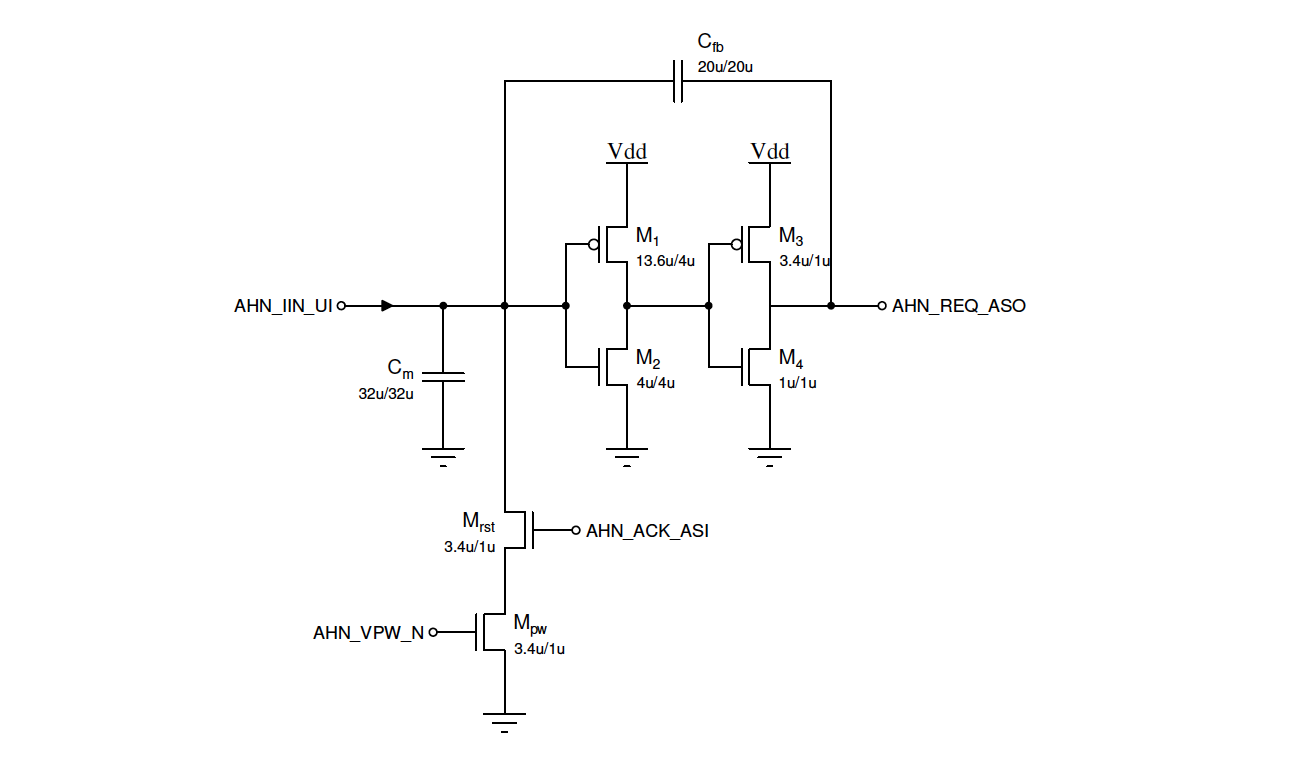

## 2.1 Basic measurement

* Tune `AHN_VPW_N` bias so that the output waveform is more or less symmetric.

In [17]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.AHN_VPW_N,\
    pyplane.Coach.BiasType.N,\
    pyplane.Coach.BiasGenMasterCurrent.I60pA,2)])

* Data aquisition

In [18]:
N_samples = 50
dT = 0.05

t = np.arange(N_samples)*dT
v = np.zeros(N_samples) # v_Cm

for i in range(N_samples):
    v[i] = p.read_voltage(pyplane.AdcChannel.AOUT11)
    time.sleep(dT)

* Plot data

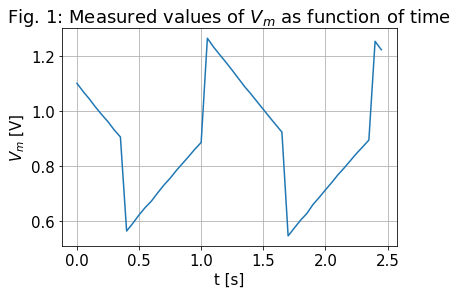

In [19]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})


t,v = np.loadtxt('data_ex_2_1.csv',delimiter=',')

plt.plot(t,v)

plt.xlabel('t [s]')
plt.ylabel('$V_{m}$ [V]')
plt.title('Fig. 1: Measured values of $V_{m}$ as function of time')

plt.grid()
plt.show()

* Save data

In [20]:
np.savetxt('data_ex_2_1.csv',[t,v] , delimiter=',')

## 2.2 Different pulse widths

Now try two more `AHN_VPW_N` values and compare the three curves in the same plot.

In [21]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.AHN_VPW_N,\
    pyplane.Coach.BiasType.N,\
    pyplane.Coach.BiasGenMasterCurrent.I60pA,1)])

In [22]:
N_samples = 50
dT = 0.05

t = np.arange(N_samples)*dT
v = np.zeros(N_samples) # v_Cm

for i in range(N_samples):
    v[i] = p.read_voltage(pyplane.AdcChannel.AOUT11)
    time.sleep(dT)

In [23]:
np.savetxt('data_ex_2_2_smaller.csv',[t,v] , delimiter=',')

In [24]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.AHN_VPW_N,\
    pyplane.Coach.BiasType.N,\
    pyplane.Coach.BiasGenMasterCurrent.I60pA,30)])

In [25]:
N_samples = 50
dT = 0.05

t = np.arange(N_samples)*dT
v = np.zeros(N_samples) # v_Cm

for i in range(N_samples):
    v[i] = p.read_voltage(pyplane.AdcChannel.AOUT11)
    time.sleep(dT)

In [26]:
np.savetxt('data_ex_2_2_bigger.csv',[t,v] , delimiter=',')

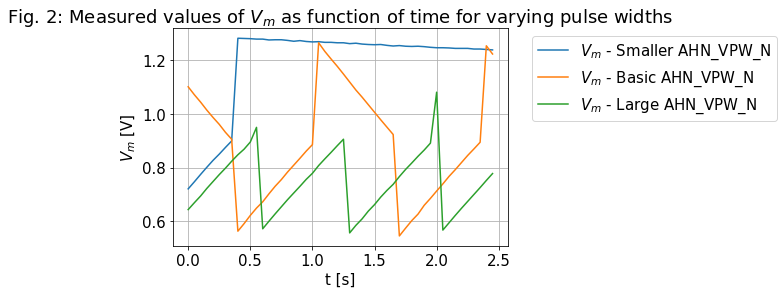

In [27]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 15})

t,v = np.loadtxt('data_ex_2_1.csv',delimiter=',')
_,v_smaller = np.loadtxt('data_ex_2_2_smaller.csv',delimiter=',')
_,v_bigger = np.loadtxt('data_ex_2_2_bigger.csv',delimiter=',')

plt.plot(t,v_smaller,t,v,t,v_bigger)
plt.legend(['$V_{m}$ - Smaller AHN_VPW_N','$V_{m}$ - Basic AHN_VPW_N','$V_{m}$ - Large AHN_VPW_N'],bbox_to_anchor=(1.05, 1),loc='upper left') 

plt.xlabel('t [s]')
plt.ylabel('$V_{m}$ [V]')
plt.title('Fig. 2: Measured values of $V_{m}$ as function of time for varying pulse widths')

plt.grid()
plt.show()

## 2.3 Switch off the circuit

* To avoid the output events interfering with other circuits, we set `AHN_VPW_N` to maximum again. 

In [28]:
# disable axon-hillock neuron
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.AHN_VPW_N, \
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 0)])

# 3 Basic behavoir of classic I&F neuron

The **ADEXIF** (Adaptive Exponential Integrate & Fire) **classic neuron** comprises four major functional blocks: a leaky DPI (=integrate), starved-inverter (=fire), refractory period (=reset) and adaptation block.
The adaptation block receives the the spike pulse of the neuron itself through a pulse extender circuit.

The circuit receives an input current $I_{in}$ (typically the output of a synapse, $I_{syn}$) and outputs an AER event.

The membrane voltage $V_{mem}$ is provided to observe the internal neuron state at **ADC[10]**.

The neuron circuit has 4 basic biases: $V_{dc}$, $V_{gain}$, $V_{leak}$ and $V_{refr}$. The adaptation block has 5 more biases: $V_{adpgain}$, $V_{adpweight}$, $V_{adptau}$, $V_{adpcasc}$ & $V_{adpptau}$ (for the pulse extender).

There are two digital control bits: $V_{adpen}$ to enable/disable adaptation, and $V_{dcen}$ to disable/enable the $V_{dc}$ bias input.

$C_{m}$ sizing was chosen for a capacitance value of $2$ pF, while $C_{refr}$ and $C_{adp}$ were chosen for a value of $1$ pF. 

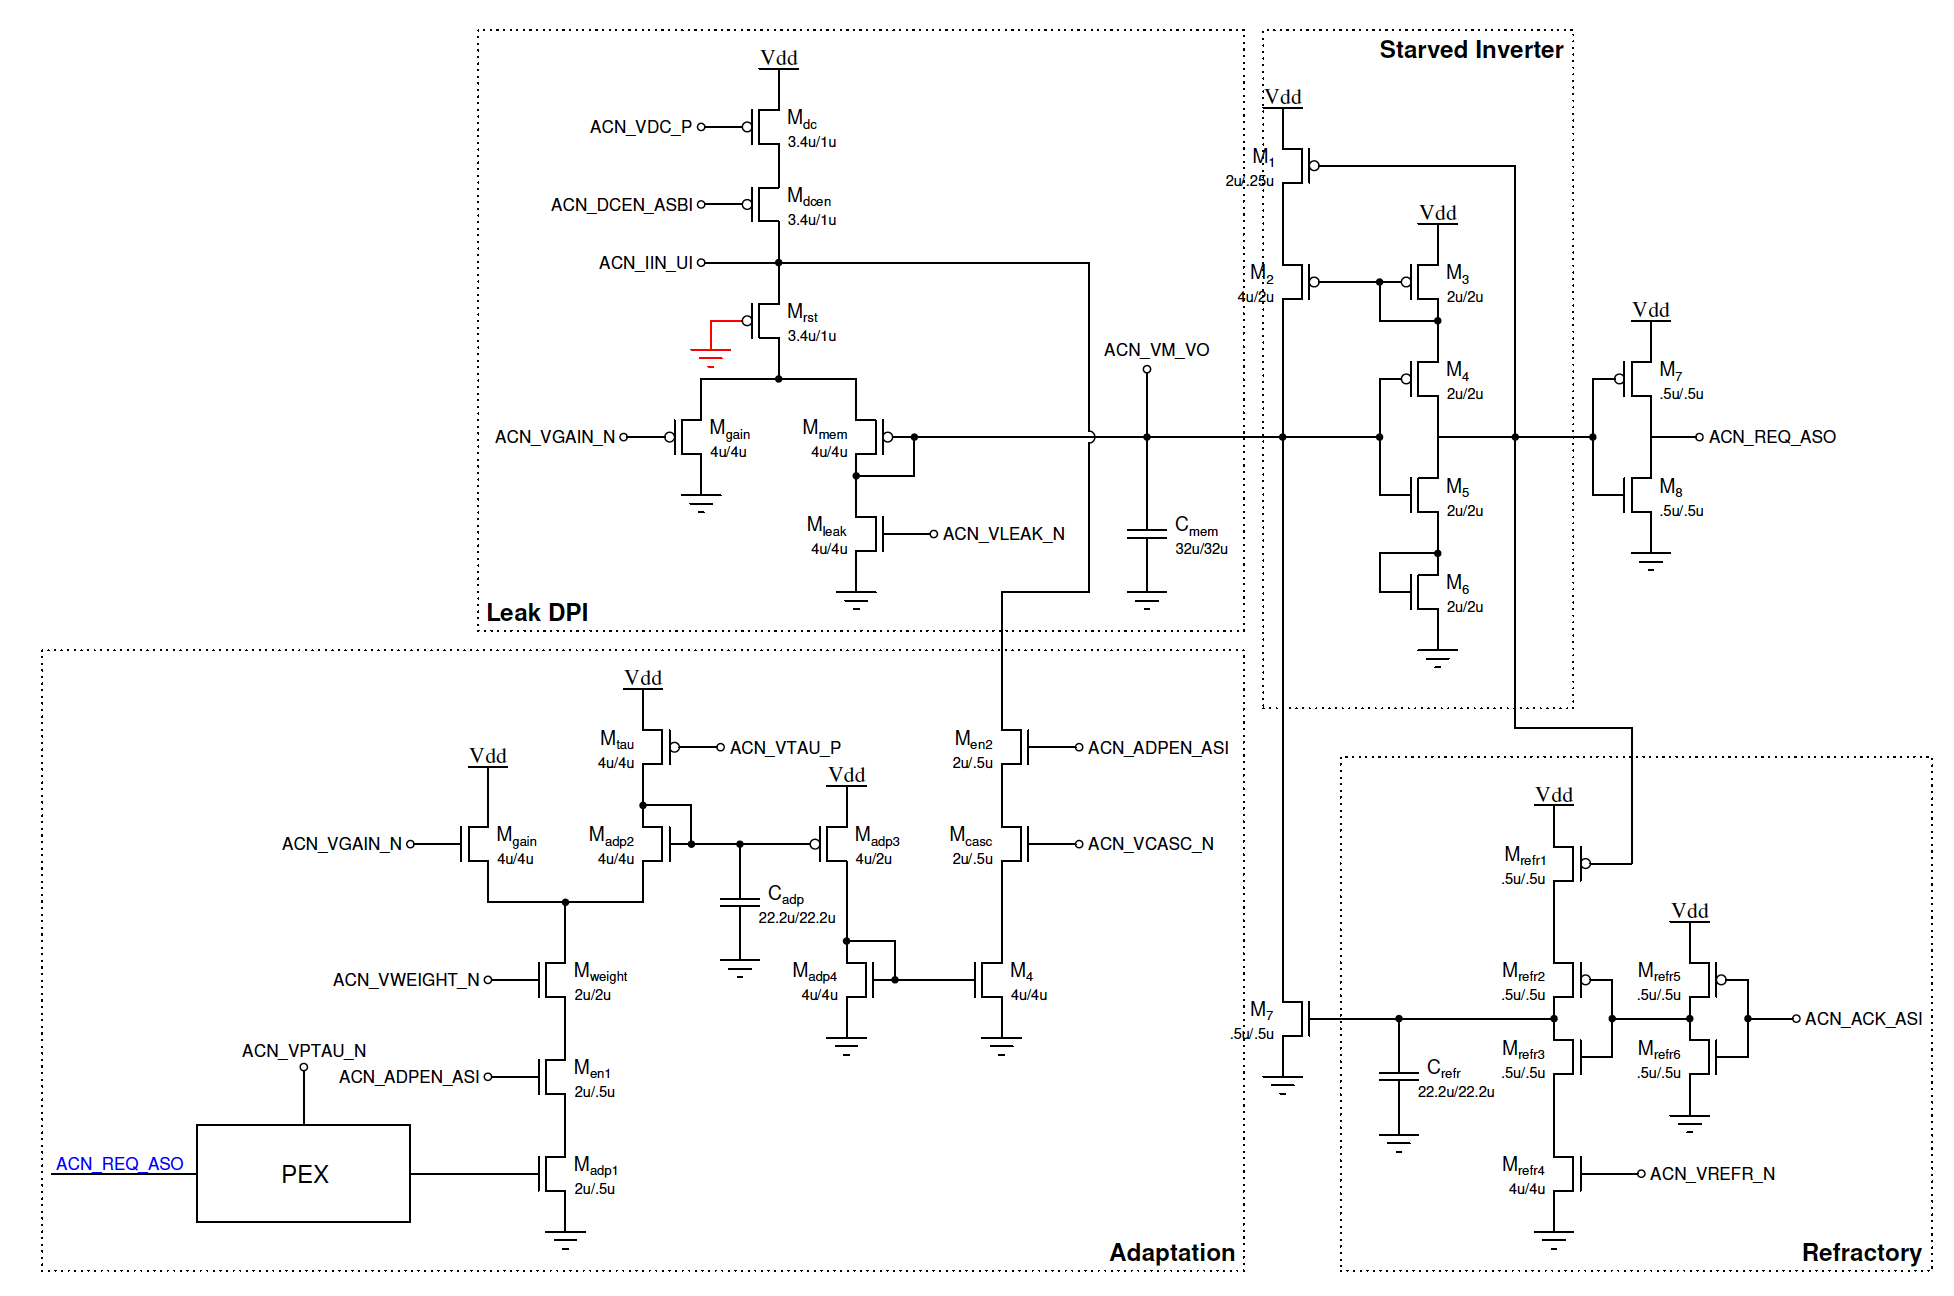

## 3.1 Basic measurement

* Tune the biases such that the neuron fires at about 20 Hz.

In [29]:
p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VLEAK_N,\
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 2)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VGAIN_N,\
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I60pA, 6)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VDC_P,\
    pyplane.Coach.BiasType.P, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 32)])

p.send_coach_events([pyplane.Coach.generate_biasgen_event(\
    pyplane.Coach.BiasAddress.ACN_VREFR_N,\
    pyplane.Coach.BiasType.N, \
    pyplane.Coach.BiasGenMasterCurrent.I30nA, 8)]) #cahnge refractory period

* read data

In [30]:
vm1 = p.acquire_transient_response(pyplane.DacChannel.DAC1, pyplane.AdcChannel.AOUT10, 0.00025, 1)

* Plot data

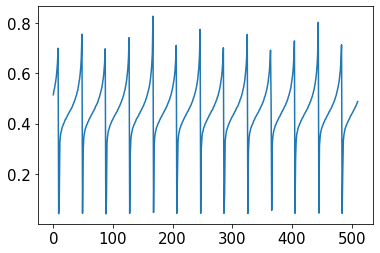

In [31]:
plt.plot(vm1)

## 3.2 Refractory period

Repeat 3.1 with two other refractory period biases and compare.